> # **Análisis de Datos Exploratorio y Análisis de Datos Descriptivo - DataFrame con 10 Millones de Eventos en un Ecommerce**

*Nuestro proyecto se fundamenta en un proceso analítico integral que transforma 10 millones de eventos brutos en insights estratégicos. La extracción de datos se realiza desde Kaggle mediante su API, proporcionándonos un dataset amplio y multidimensional. Con la combinación de Python y SQL a través de DuckDB, cargamos, depuramos y transformamos la información, garantizando la calidad y confiabilidad de los datos para el análisis.*

*La primera fase se centra en el análisis descriptivo. Para las variables numéricas, como el precio (Price), calculamos medidas de tendencia central y dispersión (media, mediana, mínimos, máximos y desviación estándar) para comprender la distribución y detectar outliers mediante histogramas y diagramas de caja (boxplots). Esto nos permite identificar patrones de precio y anomalías en las transacciones.*

*Simultáneamente, se exploran las variables categóricas, tales como el tipo de evento (EventType), marca (BrandImputed), clasificación de la categoría (CategoryImputed), categoría principal (PrincipalCategory) y las subcategorías (SubCategory y SubCategory2). A través de gráficos de barras y pie charts, evaluamos la frecuencia y proporción de cada categoría, lo que nos ayuda a identificar las marcas y categorías más activas, así como a resaltar los top 10 productos y marcas en términos de conversión.*

*El análisis exploratorio profundiza en preguntas clave que orientan la estrategia del negocio. Por ejemplo, se investiga la tasa de conversión de visualizaciones a compras, identificando los productos con más de 5 visualizaciones y su rendimiento en conversión. Asimismo, se analiza cuántos views se generan en promedio antes de concretar una compra y se segmenta la tasa de conversión por marca, categoría principal y subcategorías, utilizando tanto gráficos de barras como histogramas para visualizar estas métricas.*

*Cada etapa del proceso se respalda en visualizaciones interactivas con Plotly y análisis complementarios con Seaborn, facilitando una narrativa visual clara y dinámica. La eficiencia en la manipulación de grandes volúmenes de datos se logra gracias a SQL con DuckDB, mientras que Python nos permite explorar y representar visualmente los resultados de manera detallada.*

*En resumen, nuestro proyecto integra la potencia de Python y la eficiencia de SQL (DuckDB) para transformar 10 millones de eventos en un análisis profundo y visualmente enriquecido. Desde la limpieza y transformación de los datos hasta la exploración y visualización, cada fase está diseñada para extraer conocimientos significativos, que faciliten la toma de decisiones estratégicas y abran la puerta a futuras investigaciones y mejoras continuas.*

**https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/data**

**https://rees46.com/**


> # **Diccionario de Variables**

| **Propiedad**      | **Descripción**                                                                                   | **Ejemplo**                        |
|:------------------:|:------------------------------------------------------------------------------------------------:|:----------------------------------:|
| **EventTime**      | Fecha y hora en que ocurrió el evento, registrada en formato UTC.                                  | 2019-10-01 00:00:00               |
| **UserSession**    | Identificador único de la sesión de usuario. Se mantiene constante durante la misma sesión.        | 72d76fde-8bb3-4e00-8c23-a032dfed738c |
| **UserID**         | Identificador único y permanente para cada usuario registrado.                                     | 541312140                          |
| **ProductID**      | Identificador único para cada producto en la tienda.                                               | 44600062                           |
| **CategoryID**     | Identificador único para la categoría a la que pertenece el producto.                              | 2103807459595387724                |
| **EventType**      | Tipo de evento que se registró, como "view" (visualización).                                       | view                               |
| **Price**          | Precio del producto, expresado como un número decimal.                                             | 35.79                              |
| **BrandImputed**   | Marca del producto, en minúsculas. Si no está disponible, se indica como "Unknown".                 | shiseido                           |
| **CategoryImputed**| Clasificación jerárquica de la categoría del producto. Si no está disponible, se indica como "Unknown". | Unknown                            |
| **PrincipalCategory** | Categoría principal del producto. Si no está disponible, se indica como "Unknown".              | Unknown                            |
| **SubCategory**    | Subcategoría del producto. Si no está disponible, se indica como "Unknown".                        | Unknown                            |
| **SubCategory2**   | Subcategoría secundaria del producto. Si no está disponible, se indica como "Unknown".             | Unknown                            |
| **SubCategory3**   | Subcategoría terciaria del producto. Si no está disponible, se indica como "Unknown".              | Unknown                            |


In [1]:
# Instalamos la API de Kaggle (si aún no está instalada)
!pip install kaggle
!pip install duckdb

# Descargamos el dataset en el directorio actual (/content)
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store -p /content


import zipfile
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Abrimos y leemos el .ZIP que contiene la Carpeta con el DataSet
with zipfile.ZipFile('/content/ecommerce-behavior-data-from-multi-category-store.zip', 'r') as zip_ref:

    # Extraemos el contenido del .ZIP que acabamos de abrir con la carpeta
    zip_ref.extractall('/content/ecommerce-behavior-data-from-multi-category-store')

# Conexión a DuckDB en memoria
con = duckdb.connect(database='ecommerceEvents.duckdb')

# 1. Leer el CSV de Octubre usando read_csv_auto y crear una tabla temporal imputando los valores nulos y asignándoles etiquetas, incluyendo las columnas de las categorías.
csv_path_oct = 'ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv'
con.execute(f"""
CREATE TABLE IF NOT EXISTS ecommerceEvents AS (
  WITH cte AS (
    SELECT *,
           COALESCE(category_code, 'Unknown') AS categoryImputed,
           COALESCE(brand, 'Unknown') AS brandImputed
    FROM read_csv_auto('{csv_path_oct}')
    LIMIT 10000000
  )
  SELECT
    cte.*,
    CASE
      WHEN cte.categoryImputed IS NULL THEN 'Unknown'
      ELSE split_part(cte.categoryImputed, '.', 1)
    END AS PrincipalCategory,
    CASE
      WHEN cte.categoryImputed IS NULL OR strpos(cte.categoryImputed, '.') = 0 THEN 'Unknown'
      ELSE split_part(cte.categoryImputed, '.', 2)
    END AS SubCategory,
    CASE
      WHEN cte.categoryImputed IS NULL OR (length(cte.categoryImputed) - length(replace(cte.categoryImputed, '.', ''))) < 2 THEN 'Unknown'
      ELSE split_part(cte.categoryImputed, '.', 3)
    END AS SubCategory2,
    CASE
      WHEN cte.categoryImputed IS NULL OR (length(cte.categoryImputed) - length(replace(cte.categoryImputed, '.', ''))) < 3 THEN 'Unknown'
      ELSE split_part(cte.categoryImputed, '.', 4)
    END AS SubCategory3
  FROM cte
);
""")

Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
100% 4.29G/4.29G [01:47<00:00, 45.5MB/s]
100% 4.29G/4.29G [01:47<00:00, 42.9MB/s]


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
query_Events = """
SELECT ecoev.event_time AS EventTime
,ecoev.user_session AS UserSession
,ecoev.user_id AS UserID
,ecoev.product_id AS ProductID
,ecoev.category_id AS CategoryID
,ecoev.event_type AS EventType
,ecoev.price AS Price
,ecoev.brandImputed AS BrandImputed
,ecoev.categoryImputed AS CategoryImputed
,ecoev.PrincipalCategory
,ecoev.SubCategory
,ecoev.Subcategory2
,ecoev.SubCategory3
FROM ecommerceEvents ecoev
"""

df_Events = con.execute(query_Events).fetchdf()

df_Events.head(10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,EventTime,UserSession,UserID,ProductID,CategoryID,EventType,Price,BrandImputed,CategoryImputed,PrincipalCategory,SubCategory,SubCategory2,SubCategory3
0,2019-10-01 00:00:00,72d76fde-8bb3-4e00-8c23-a032dfed738c,541312140,44600062,2103807459595387724,view,35.79,shiseido,Unknown,Unknown,Unknown,Unknown,Unknown
1,2019-10-01 00:00:00,9333dfbd-b87a-4708-9857-6336556b0fcc,554748717,3900821,2053013552326770905,view,33.20,aqua,appliances.environment.water_heater,appliances,environment,water_heater,Unknown
2,2019-10-01 00:00:01,566511c2-e2e3-422b-b695-cf8e6e792ca8,519107250,17200506,2053013559792632471,view,543.10,Unknown,furniture.living_room.sofa,furniture,living_room,sofa,Unknown
3,2019-10-01 00:00:01,7c90fc70-0e80-4590-96f3-13c02c18c713,550050854,1307067,2053013558920217191,view,251.74,lenovo,computers.notebook,computers,notebook,Unknown,Unknown
4,2019-10-01 00:00:04,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,535871217,1004237,2053013555631882655,view,1081.98,apple,electronics.smartphone,electronics,smartphone,Unknown,Unknown
5,2019-10-01 00:00:05,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,512742880,1480613,2053013561092866779,view,908.62,pulser,computers.desktop,computers,desktop,Unknown,Unknown
6,2019-10-01 00:00:08,4fe811e9-91de-46da-90c3-bbd87ed3a65d,555447699,17300353,2053013553853497655,view,380.96,creed,Unknown,Unknown,Unknown,Unknown,Unknown
7,2019-10-01 00:00:08,6280d577-25c8-4147-99a7-abc6048498d6,550978835,31500053,2053013558031024687,view,41.16,luminarc,Unknown,Unknown,Unknown,Unknown,Unknown
8,2019-10-01 00:00:10,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,520571932,28719074,2053013565480109009,view,102.71,baden,apparel.shoes.keds,apparel,shoes,keds,Unknown
9,2019-10-01 00:00:11,406c46ed-90a4-4787-a43b-59a410c1a5fb,537918940,1004545,2053013555631882655,view,566.01,huawei,electronics.smartphone,electronics,smartphone,Unknown,Unknown


## A continuación realizamos las siguientes operaciones en el DataFrame:

- Conversión de tipos de datos en las columnas.
- Visualizamos la información del dataframe y sus columnas.
- Verificamos la cantidad de nulos y nan.
- Eliminamos los valores duplicados.

In [3]:
df_Events['EventTime'] = pd.to_datetime(df_Events['EventTime'])

In [4]:
df_Events.head(15)

,EventTime,UserSession,UserID,ProductID,CategoryID,EventType,Price,BrandImputed,CategoryImputed,PrincipalCategory,SubCategory,SubCategory2,SubCategory3
0,2019-10-01 00:00:00,72d76fde-8bb3-4e00-8c23-a032dfed738c,541312140,44600062,2103807459595387724,view,35.79,shiseido,Unknown,Unknown,Unknown,Unknown,Unknown
1,2019-10-01 00:00:00,9333dfbd-b87a-4708-9857-6336556b0fcc,554748717,3900821,2053013552326770905,view,33.20,aqua,appliances.environment.water_heater,appliances,environment,water_heater,Unknown
2,2019-10-01 00:00:01,566511c2-e2e3-422b-b695-cf8e6e792ca8,519107250,17200506,2053013559792632471,view,543.10,Unknown,furniture.living_room.sofa,furniture,living_room,sofa,Unknown
3,2019-10-01 00:00:01,7c90fc70-0e80-4590-96f3-13c02c18c713,550050854,1307067,2053013558920217191,view,251.74,lenovo,computers.notebook,computers,notebook,Unknown,Unknown
4,2019-10-01 00:00:04,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,535871217,1004237,2053013555631882655,view,1081.98,apple,electronics.smartphone,electronics,smartphone,Unknown,Unknown
5,2019-10-01 00:00:05,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,512742880,1480613,2053013561092866779,view,908.62,pulser,computers.desktop,computers,desktop,Unknown,Unknown
6,2019-10-01 00:00:08,4fe811e9-91de-46da-90c3-bbd87ed3a65d,555447699,17300353,2053013553853497655,view,380.96,creed,Unknown,Unknown,Unknown,Unknown,Unknown
7,2019-10-01 00:00:08,6280d577-25c8-4147-99a7-abc6048498d6,550978835,31500053,2053013558031024687,view,41.16,luminarc,Unknown,Unknown,Unknown,Unknown,Unknown
8,2019-10-01 00:00:10,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,520571932,28719074,2053013565480109009,view,102.71,baden,apparel.shoes.keds,apparel,shoes,keds,Unknown
9,2019-10-01 00:00:11,406c46ed-90a4-4787-a43b-59a410c1a5fb,537918940,1004545,2053013555631882655,view,566.01,huawei,electronics.smartphone,electronics,smartphone,Unknown,Unknown


In [5]:
df_Events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   EventTime          datetime64[us]
 1   UserSession        object        
 2   UserID             int64         
 3   ProductID          int64         
 4   CategoryID         int64         
 5   EventType          object        
 6   Price              float64       
 7   BrandImputed       object        
 8   CategoryImputed    object        
 9   PrincipalCategory  object        
 10  SubCategory        object        
 11  SubCategory2       object        
 12  SubCategory3       object        
dtypes: datetime64[us](1), float64(1), int64(3), object(8)
memory usage: 991.8+ MB


In [6]:
df_Events['Price'].describe()

,Price
count,1.000000e+07
mean,2.960614e+02
std,3.669101e+02
min,0.000000e+00
25%,6.525000e+01
50%,1.619100e+02
75%,3.618200e+02
max,2.574070e+03


In [7]:
df_Events.isnull().sum()

,0
EventTime,0
UserSession,1
UserID,0
ProductID,0
CategoryID,0
EventType,0
Price,0
BrandImputed,0
CategoryImputed,0
PrincipalCategory,0


In [8]:
df_Events.dropna(inplace=True)

---
### Análisis Descriptivo de Variables Numéricas
- Variables Numéricas (Medidas de tendencia central y dispersión)
---

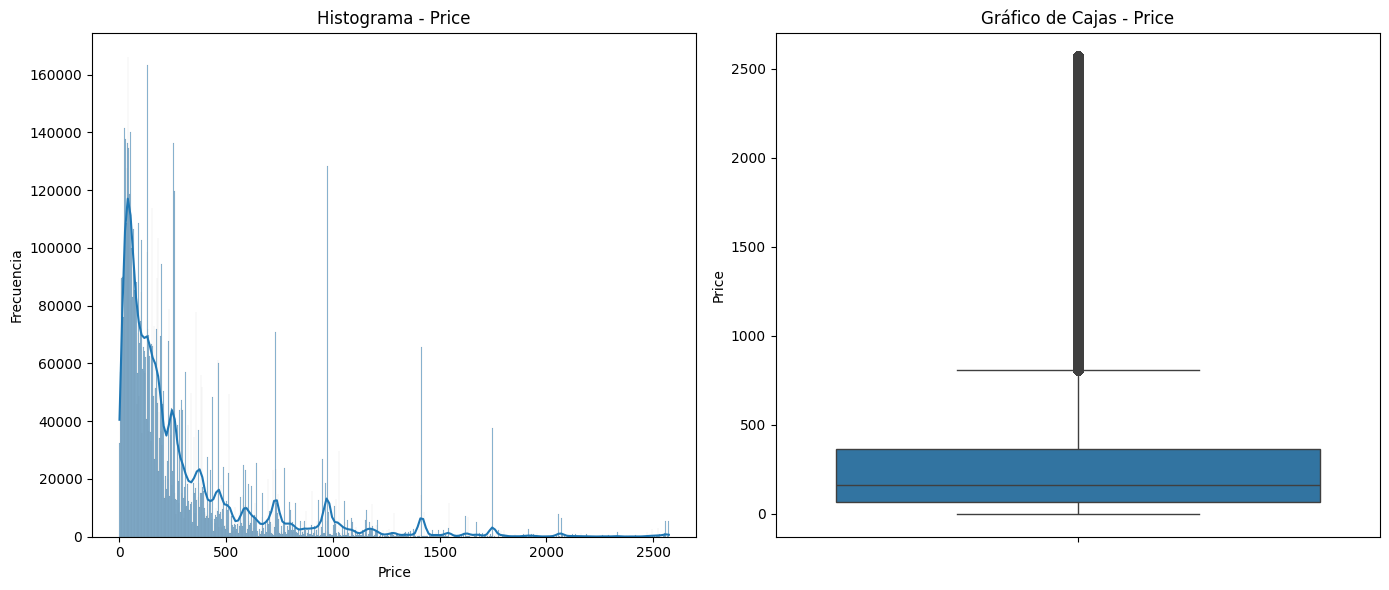

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1, ax2 = axes.flatten()

sns.histplot(data=df_Events, x="Price", ax=ax1, kde=True)
ax1.set_title('Histograma - Price', fontsize=12)
ax1.set_xlabel("Price")
ax1.set_ylabel("Frecuencia")

sns.boxplot(data=df_Events, y="Price", ax=ax2)
ax2.set_title('Gráfico de Cajas - Price', fontsize=12)
ax2.set_ylabel("Price")

plt.tight_layout()
plt.show()

---
### Análisis Descriptivo de Variables Categóricas
- Frecuencia y proporción
---

In [10]:
query_Ecommerce_EventType = """
WITH cte_Ecommerce_EventType AS (
  SELECT ecoev.event_time AS EventTime
  ,ecoev.user_session AS UserSession
  ,ecoev.user_id AS UserID
  ,ecoev.product_id AS ProductID
  ,ecoev.category_id AS CategoryID
  ,ecoev.event_type AS EventType
  ,ecoev.price AS Price
  ,ecoev.brandImputed AS BrandImputed
  ,ecoev.categoryImputed AS CategoryImputed
  ,ecoev.PrincipalCategory
  ,ecoev.SubCategory
  ,ecoev.Subcategory2
  ,ecoev.SubCategory3
  FROM ecommerceEvents ecoev
) SELECT cee.EventType
,COUNT(1) AS Cantidad
FROM cte_Ecommerce_EventType cee
GROUP BY cee.EventType
ORDER BY Cantidad DESC
"""

df_Events_EventType = con.execute(query_Ecommerce_EventType).fetchdf()

query_Ecommerce_BrandImputed = """
WITH cte_Ecommerce_BrandImputed AS (
  SELECT ecoev.event_time AS EventTime
  ,ecoev.user_session AS UserSession
  ,ecoev.user_id AS UserID
  ,ecoev.product_id AS ProductID
  ,ecoev.category_id AS CategoryID
  ,ecoev.event_type AS EventType
  ,ecoev.price AS Price
  ,ecoev.brandImputed AS BrandImputed
  ,ecoev.categoryImputed AS CategoryImputed
  ,ecoev.PrincipalCategory
  ,ecoev.SubCategory
  ,ecoev.Subcategory2
  ,ecoev.SubCategory3
  FROM ecommerceEvents ecoev
) SELECT ceb.BrandImputed
,COUNT(1) AS Cantidad
FROM cte_Ecommerce_BrandImputed ceb
GROUP BY ceb.BrandImputed
ORDER BY Cantidad DESC
LIMIT 10
"""

df_Events_BrandImputed = con.execute(query_Ecommerce_BrandImputed).fetchdf()

query_Ecommerce_CategoryImputed = """
WITH cte_Ecommerce_CategoryImputed AS (
  SELECT ecoev.event_time AS EventTime
  ,ecoev.user_session AS UserSession
  ,ecoev.user_id AS UserID
  ,ecoev.product_id AS ProductID
  ,ecoev.category_id AS CategoryID
  ,ecoev.event_type AS EventType
  ,ecoev.price AS Price
  ,ecoev.brandImputed AS BrandImputed
  ,ecoev.categoryImputed AS CategoryImputed
  ,ecoev.PrincipalCategory
  ,ecoev.SubCategory
  ,ecoev.Subcategory2
  ,ecoev.SubCategory3
  FROM ecommerceEvents ecoev
) SELECT ceci.CategoryImputed
,COUNT(1) AS Cantidad
FROM cte_Ecommerce_CategoryImputed ceci
GROUP BY ceci.CategoryImputed
ORDER BY Cantidad DESC
LIMIT 10
"""

df_Events_CategoryImputed = con.execute(query_Ecommerce_CategoryImputed).fetchdf()

query_Ecommerce_PrincipalCategory = """
WITH cte_Ecommerce_PrincipalCategory AS (
  SELECT ecoev.event_time AS EventTime
  ,ecoev.user_session AS UserSession
  ,ecoev.user_id AS UserID
  ,ecoev.product_id AS ProductID
  ,ecoev.category_id AS CategoryID
  ,ecoev.event_type AS EventType
  ,ecoev.price AS Price
  ,ecoev.brandImputed AS BrandImputed
  ,ecoev.categoryImputed AS CategoryImputed
  ,ecoev.PrincipalCategory
  ,ecoev.SubCategory
  ,ecoev.Subcategory2
  ,ecoev.SubCategory3
  FROM ecommerceEvents ecoev
) SELECT cepc.PrincipalCategory
,COUNT(1) AS Cantidad
FROM cte_Ecommerce_PrincipalCategory cepc
GROUP BY cepc.PrincipalCategory
ORDER BY Cantidad DESC
LIMIT 10
"""

df_Events_PrincipalCategory = con.execute(query_Ecommerce_PrincipalCategory).fetchdf()

query_Ecommerce_SubCategory = """
WITH cte_Ecommerce_PrincipalCategory AS (
  SELECT ecoev.event_time AS EventTime
  ,ecoev.user_session AS UserSession
  ,ecoev.user_id AS UserID
  ,ecoev.product_id AS ProductID
  ,ecoev.category_id AS CategoryID
  ,ecoev.event_type AS EventType
  ,ecoev.price AS Price
  ,ecoev.brandImputed AS BrandImputed
  ,ecoev.categoryImputed AS CategoryImputed
  ,ecoev.PrincipalCategory
  ,ecoev.SubCategory
  ,ecoev.Subcategory2
  ,ecoev.SubCategory3
  FROM ecommerceEvents ecoev
) SELECT cepc.SubCategory
,COUNT(1) AS Cantidad
FROM cte_Ecommerce_PrincipalCategory cepc
GROUP BY cepc.SubCategory
ORDER BY Cantidad DESC
LIMIT 10
"""

df_Events_SubCategory = con.execute(query_Ecommerce_SubCategory).fetchdf()

query_Ecommerce_SubCategory2 = """
WITH cte_Ecommerce_SubCategory2 AS (
  SELECT ecoev.event_time AS EventTime
  ,ecoev.user_session AS UserSession
  ,ecoev.user_id AS UserID
  ,ecoev.product_id AS ProductID
  ,ecoev.category_id AS CategoryID
  ,ecoev.event_type AS EventType
  ,ecoev.price AS Price
  ,ecoev.brandImputed AS BrandImputed
  ,ecoev.categoryImputed AS CategoryImputed
  ,ecoev.PrincipalCategory
  ,ecoev.SubCategory
  ,ecoev.Subcategory2
  ,ecoev.SubCategory3
  FROM ecommerceEvents ecoev
) SELECT cesc.SubCategory2
,COUNT(1) AS Cantidad
FROM cte_Ecommerce_SubCategory2 cesc
GROUP BY cesc.SubCategory2
ORDER BY Cantidad DESC
LIMIT 10
"""

df_Events_SubCategory2 = con.execute(query_Ecommerce_SubCategory2).fetchdf()

In [11]:
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[
        "Tipo de Evento", "Tipo de Marca", "Categoría",
        "Categoría Principal", "Subcategoría (#1)", "Subcategoría (#2)"
    ],
    horizontal_spacing=0.2, vertical_spacing=0.2
)

datasets = [
    (df_Events_EventType, "EventType"),
    (df_Events_BrandImputed, "BrandImputed"),
    (df_Events_CategoryImputed, "CategoryImputed"),
    (df_Events_PrincipalCategory, "PrincipalCategory"),
    (df_Events_SubCategory, "SubCategory"),
    (df_Events_SubCategory2, "SubCategory2"),
]

for i, (df, col) in enumerate(datasets):
    max_value = df["Cantidad"].max()
    df["Color"] = df["Cantidad"].apply(lambda x: "#0C5127" if x == max_value else "#4990C2")

    df['TextValues'] = ""

    max_index = df['Cantidad'].idxmax()
    min_index = df['Cantidad'].idxmin()
    df.loc[max_index, 'TextValues'] = df.loc[max_index, 'Cantidad']
    df.loc[min_index, 'TextValues'] = df.loc[min_index, 'Cantidad']
    df.loc[~(df.index.isin([max_index, min_index])), 'TextValues'] = np.nan

    trace = go.Bar(
        x=df["Cantidad"],
        y=df[col],
        orientation="h",
        marker=dict(color=df["Color"]),
        showlegend=False,
        text=df["TextValues"],
        textposition='auto'
    )

    row, col_num = divmod(i, 2)
    fig.add_trace(trace, row=row + 1, col=col_num + 1)

for r in range(1, 4):
    for c in range(1, 3):
        fig.update_xaxes(title_text="Cantidad", row=r, col=c)

fig.update_layout(
    width=1200, height=900,
    title_text="Gráficos de Barras Comparativos",
    showlegend=False
)

fig.show()

---
### Análisis Exploratorio
- El enfoque exploratorio se centra en descubrir patrones y relaciones entre variables que puedan aportar insights adicionales.
---

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Qué porcentaje de productos visualizados termina siendo comprado (Top 10 Productos con Mayor Tasa de Conversión (Más de 5 Visualizaciones))?
---



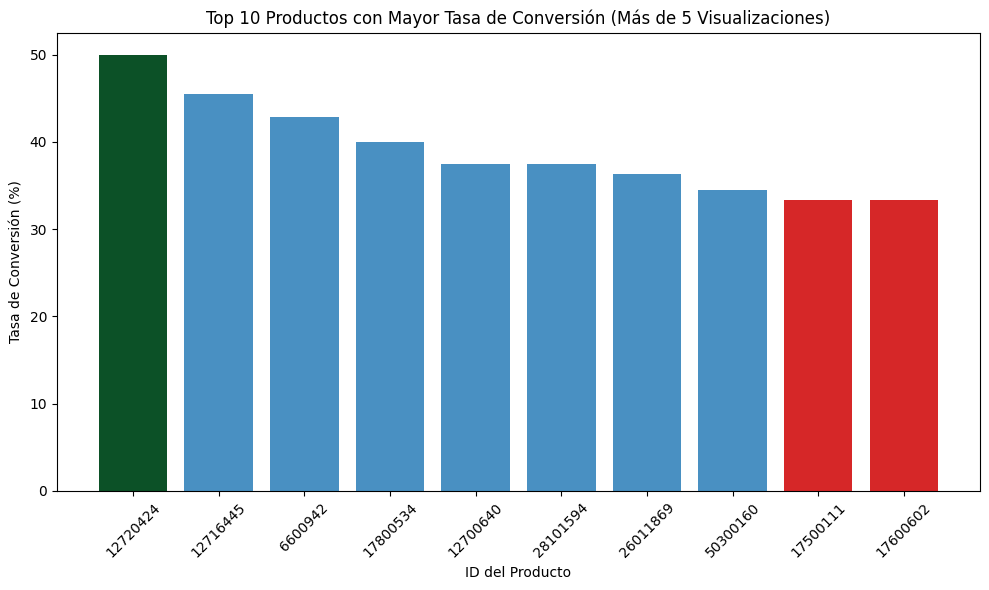

In [12]:
query_Ecommerce_ConversionRate = """
WITH ProductViews AS (
    SELECT product_id AS ProductID
    ,COUNT(*) AS views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY ProductID
),
ProductPurchases AS (
    SELECT product_id AS ProductID
    ,COUNT(*) AS purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY ProductID
)
SELECT
    pv.ProductID,
    pv.views,
    COALESCE(pp.purchases, 0) AS purchases,
    (COALESCE(pp.purchases, 0) * 100.0 / pv.views) AS conversion_rate
FROM ProductViews pv
LEFT JOIN ProductPurchases pp ON pv.ProductID = pp.ProductID
WHERE pv.views > 5
ORDER BY conversion_rate DESC
LIMIT 10;
"""

df_Events_ConversionRate_FiveViews = con.execute(query_Ecommerce_ConversionRate).fetchdf()

df_Events_ConversionRate_FiveViews['ProductID'] = df_Events_ConversionRate_FiveViews['ProductID'].astype(str)

max_value = df_Events_ConversionRate_FiveViews["conversion_rate"].max()
min_value = df_Events_ConversionRate_FiveViews["conversion_rate"].min()

colors = df_Events_ConversionRate_FiveViews["conversion_rate"].apply(lambda x: "#0C5127" if x == max_value else "#D62728" if x == min_value else "#4990C2")

plt.figure(figsize=(10, 6))
plt.bar(df_Events_ConversionRate_FiveViews["ProductID"], df_Events_ConversionRate_FiveViews["conversion_rate"], color=colors)
plt.xlabel("ID del Producto")
plt.ylabel("Tasa de Conversión (%)")
plt.title("Top 10 Productos con Mayor Tasa de Conversión (Más de 5 Visualizaciones)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [13]:
query_Ecommerce_ConversionRate2 = """
WITH ProductViews AS (
    SELECT product_id AS ProductID
    ,COUNT(*) AS views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY ProductID
),
ProductPurchases AS (
    SELECT product_id AS ProductID
    ,COUNT(*) AS purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY ProductID
)
SELECT
    pv.ProductID,
    pv.views,
    COALESCE(pp.purchases, 0) AS purchases,
    (COALESCE(pp.purchases, 0) * 100.0 / pv.views) AS conversion_rate
FROM ProductViews pv
LEFT JOIN ProductPurchases pp ON pv.ProductID = pp.ProductID
WHERE pv.views > 5
ORDER BY conversion_rate DESC
"""

df_Events_ConversionRate_FiveViews2 = con.execute(query_Ecommerce_ConversionRate2).fetchdf()

df_Events_ConversionRate_FiveViews2.head(10)

fig_hist = px.histogram(
    df_Events_ConversionRate_FiveViews2,
    x="conversion_rate",
    nbins=20,
    title="Distribución de la Tasa de Conversión",
    labels={"conversion_rate": "Tasa de Conversión (%)"}
)

fig_hist.show()

## Conclusión General:

1. Comportamiento General de los Usuarios
- **Baja Conversión General:**  
  - Se observa que **118,763 productos** tienen una tasa de conversión menor al **5%**, lo que indica que la mayoría de los usuarios solo visualizan los productos sin llegar a comprarlos.
  - Solo **2,263 productos** tienen una tasa de conversión superior al **15%**, resaltando la dificultad para convertir visualizaciones en compras.

2. Análisis de Productos con Mayor Conversión (Gráfico de Barras)
- **Filtrado Relevante:**  
  - Para evitar distorsiones por productos con muy pocas visualizaciones, se consideraron únicamente aquellos productos que han sido vistos **más de 5 veces**.
- **Destacados en el Top 10:**  
  - El **producto con ID 12720424** destaca con la **mayor tasa de conversión (50%)**.
  - Los **productos con IDs 17500111 y 26008763** se encuentran entre los que presentan la tasa de conversión más baja en el grupo (ambos con **33.33%**).

3. Implicaciones y Recomendaciones para el E-commerce
- **Identificar Patrones de Éxito:**  
  - Analizar las características de los productos con alta tasa de conversión puede ayudar a replicar esos factores en otros productos.
- **Estrategias de Retargeting:**  
  - Desarrollar campañas específicas para usuarios que han visto un producto pero no han realizado la compra, incentivando la conversión.
- **Optimización de la Oferta:**  
  - Evaluar ajustes en precios, descripciones o la incorporación de promociones y descuentos para aumentar la conversión en productos con alta visualización.


---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Qué porcentaje de productos visualizados termina siendo comprado por Brand?
---

In [14]:
query_Ecommerce_Brand_ConversionRate = """
WITH BrandViews AS (
    SELECT brandImputed
    ,COUNT(*) AS Views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY brandImputed
),
BrandPurchases AS (
    SELECT brandImputed
    ,COUNT(*) AS Purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY brandImputed
),
ConversionRates AS (
    SELECT
        bv.brandImputed,
        bv.Views,
        COALESCE(bp.Purchases, 0) AS Purchases,
        (COALESCE(bp.Purchases, 0) * 100.0 / bv.Views) AS ConversionRate
    FROM BrandViews bv
    LEFT JOIN BrandPurchases bp ON bv.brandImputed = bp.brandImputed
)
SELECT brandImputed, Views, Purchases, ConversionRate
FROM ConversionRates
ORDER BY ConversionRate DESC
LIMIT 10;
"""

df_Events_ConversionRate_Brand = con.execute(query_Ecommerce_Brand_ConversionRate).fetchdf()

df_Events_ConversionRate_Brand['Color'] = np.where(df_Events_ConversionRate_Brand['ConversionRate'] == df_Events_ConversionRate_Brand['ConversionRate'].max(), '#0C5127', '#4990C2')

df_Events_ConversionRate_Brand['TextValues'] = ""
max_index = df_Events_ConversionRate_Brand['ConversionRate'].idxmax()
min_index = df_Events_ConversionRate_Brand['ConversionRate'].idxmin()
df_Events_ConversionRate_Brand.loc[max_index, 'TextValues'] = df_Events_ConversionRate_Brand.loc[max_index, 'ConversionRate']
df_Events_ConversionRate_Brand.loc[min_index, 'TextValues'] = df_Events_ConversionRate_Brand.loc[min_index, 'ConversionRate']
df_Events_ConversionRate_Brand.loc[~(df_Events_ConversionRate_Brand.index.isin([max_index, min_index])), 'TextValues'] = np.nan

fig = px.bar(df_Events_ConversionRate_Brand,
             x='ConversionRate',
             y='brandImputed',
             labels={'brandImputed': 'Marca', 'ConversionRate': 'Tasa de conversion (%)'},
             title='Top 10 Marcas por Tasa de Conversión.',
             color='Color',
             text='TextValues',
             color_discrete_map={'#0C5127': '#0C5127', '#4990C2': '#4990C2'})

fig.update_traces(textposition='auto')
fig.update_layout(showlegend=False)

fig.show()

# Conclusión General:

1. Hay una variación significativa en la tasa de conversión entre las marcas. La marca con la tasa más alta convierte a la mitad de los visitantes en clientes, mientras que la última del top 10 solo convierte a poco más del 8%. Esto indica oportunidades para optimizar la estrategia por marca.

2. Las marcas con menor tasa de conversión tienen un gran margen de mejora. Es crucial identificar los puntos débiles en la experiencia de compra de estas marcas y aplicar mejoras para aumentar las conversiones.

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Existen diferencias en la conversión de views a purchases entre distintas marcas?
---

In [15]:
query_Ecommerce_ThousandViews_ConversionRate = """
WITH BrandViews AS (
    SELECT BrandImputed
    ,COUNT(*) AS views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY BrandImputed
),
BrandPurchases AS (
    SELECT BrandImputed
    ,COUNT(*) AS purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY BrandImputed
),
ConversionRates AS (
    SELECT
        bv.BrandImputed,
        bv.views,
        COALESCE(bp.purchases, 0) AS purchases,
        (COALESCE(bp.purchases, 0) * 100.0 / bv.views) AS conversion_rate
    FROM BrandViews bv
    LEFT JOIN BrandPurchases bp ON bv.BrandImputed = bp.BrandImputed
)
SELECT BrandImputed, views, purchases, conversion_rate
FROM ConversionRates
WHERE views > 1000
ORDER BY conversion_rate DESC
LIMIT 10;
"""

df_Events_ConversionRate_ThousandViews = con.execute(query_Ecommerce_ThousandViews_ConversionRate).fetchdf()

df_Events_ConversionRate_ThousandViews.head(10)

max_value = df_Events_ConversionRate_ThousandViews["conversion_rate"].max()
min_value = df_Events_ConversionRate_ThousandViews["conversion_rate"].min()

df_Events_ConversionRate_ThousandViews["Color"] = df_Events_ConversionRate_ThousandViews["conversion_rate"].apply(
    lambda x: "#0C5127" if x == max_value else "#D62728" if x == min_value else "#4990C2"
)

fig_brand = px.bar(
    df_Events_ConversionRate_ThousandViews,
    x="brandImputed",
    y="conversion_rate",
    title="Top 10 Marcas por Tasa de Conversión (con > 1,000 visualizaciones)",
    labels={"conversion_rate": "Tasa de Conversión (%)", "brandImputed": "Marca"},
    color="Color",
    color_discrete_map={"#0C5127": "#0C5127", "#D62728": "#D62728", "#4990C2": "#4990C2"}
)

fig_brand.update_layout(showlegend=False)

fig_brand.show()

## Conclusión General:

1. **Baja Tasa de Conversión General:**  
  Las 10 marcas con más de 1,000 visualizaciones no superan una tasa de conversión del 6.5%, lo que indica que, en general, un mayor número de visualizaciones no se traduce directamente en un mayor número de compras.

2. **Ausencia de Relación Directa:**  
  La cantidad de veces que se visualiza un producto no parece tener una relación directa y proporcional con la cantidad de compras, sugiriendo que factores adicionales (como la calidad de la presentación o la estrategia de marketing) pueden influir en la conversión.

3. **Diferencias Entre Marcas:**  
  Entre las marcas analizadas, la marca **ea** destaca al presentar la tasa de conversión más alta, alcanzando un 6.4%. Esto demuestra que, aunque en términos generales la conversión es baja, hay pequeñas variaciones entre marcas que podrían ser relevantes para optimizar estrategias.

4. **Implicaciones para el Negocio:**  
  - Es importante investigar qué hace diferente a la marca **ea** y aplicar esos aprendizajes a otras marcas o productos.  
  - Se sugiere focalizar estrategias en mejorar la calidad de la experiencia del usuario y otros factores que influyen en la decisión de compra, más allá de simplemente aumentar el número de visualizaciones.

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Cuántos views, en promedio, se generan antes de que se realice una compra?
---

In [16]:
total_views = df_Events[df_Events["EventType"] == "view"].shape[0]
total_purchases = df_Events[df_Events["EventType"] == "purchase"].shape[0]

views_per_purchase = total_views / total_purchases if total_purchases > 0 else 0
print(f"En promedio, se generan {views_per_purchase:.2f} visualizaciones antes de cada compra.")

En promedio, se generan 55.71 visualizaciones antes de cada compra.


In [17]:
query_Ecommerce_ViewsBeforePurchase = """
WITH ProductViews AS (
    SELECT product_id AS ProductID
    ,COUNT(*) AS views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY ProductID
),
ProductPurchases AS (
    SELECT product_id AS ProductID
    ,COUNT(*) AS purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY ProductID
)
SELECT
    pv.ProductID,
    pv.views,
    COALESCE(pp.purchases, 0) AS purchases,
    (COALESCE(pp.purchases, 0) * 100.0 / pv.views) AS conversion_rate,
    (pv.views / COALESCE(pp.purchases,0)) AS views_per_purchase
FROM ProductViews pv
LEFT JOIN ProductPurchases pp ON pv.ProductID = pp.ProductID
WHERE COALESCE(pp.purchases, 0) > 0
"""

df_Events_ViewsBeforePurchase = con.execute(query_Ecommerce_ViewsBeforePurchase).fetchdf()

df_Events_ViewsBeforePurchase.head(10)


fig = px.histogram(
    df_Events_ViewsBeforePurchase,
    x="views_per_purchase",
    nbins=50,
    title="Distribución de Cantidad de Vistas Antes de una Compra.",
    labels={"views_per_purchase": "Vistas Antes de una Compra"},
    log_y=True
)

fig.show()

## Conclusión General:

1. **Alto número de visualizaciones antes de una compra:**  
  En promedio, se requieren *55.71 visualizaciones* antes de que un producto sea comprado. Esto indica que los usuarios suelen explorar varias veces los productos antes de tomar una decisión de compra.  

2. **Posible indecisión o comparación de productos:**  
  El alto número de views por compra podría sugerir que los clientes comparan diferentes productos, investigan características o esperan promociones antes de concretar la compra.  

3. **Oportunidad para estrategias de remarketing:**  
  Dado que los usuarios ven varias veces un producto antes de comprarlo, implementar campañas de *remarketing o recordatorios de productos vistos* podría ayudar a mejorar la tasa de conversión.

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Qué porcentaje de productos visualizados termina siendo comprado por PrincipalCategory?
---

In [18]:
query_Ecommerce_PrincipalCategory_ConversionRate = """
WITH CategoryViews AS (
    SELECT PrincipalCategory
    ,COUNT(*) AS Views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY PrincipalCategory
),
CategoryPurchases AS (
    SELECT PrincipalCategory
    ,COUNT(*) AS Purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY PrincipalCategory
),
ConversionRates AS (
    SELECT
        cv.PrincipalCategory,
        cv.Views,
        COALESCE(cp.Purchases, 0) AS Purchases,
        (COALESCE(cp.Purchases, 0) * 100.0 / cv.Views) AS ConversionRate
    FROM CategoryViews cv
    LEFT JOIN CategoryPurchases cp ON cv.PrincipalCategory = cp.PrincipalCategory
)
SELECT PrincipalCategory, Views, Purchases, ConversionRate
FROM ConversionRates
ORDER BY ConversionRate DESC
LIMIT 10;
"""

df_Events_ConversionRate_PrincipalCategory = con.execute(query_Ecommerce_PrincipalCategory_ConversionRate).fetchdf()

df_Events_ConversionRate_PrincipalCategory['Color'] = np.where(df_Events_ConversionRate_PrincipalCategory['ConversionRate'] == df_Events_ConversionRate_PrincipalCategory['ConversionRate'].max(), '#0C5127', '#4990C2')

df_Events_ConversionRate_PrincipalCategory['TextValues'] = ""
max_index = df_Events_ConversionRate_PrincipalCategory['ConversionRate'].idxmax()
min_index = df_Events_ConversionRate_PrincipalCategory['ConversionRate'].idxmin()
df_Events_ConversionRate_PrincipalCategory.loc[max_index, 'TextValues'] = df_Events_ConversionRate_PrincipalCategory.loc[max_index, 'ConversionRate']
df_Events_ConversionRate_PrincipalCategory.loc[min_index, 'TextValues'] = df_Events_ConversionRate_PrincipalCategory.loc[min_index, 'ConversionRate']
df_Events_ConversionRate_PrincipalCategory.loc[~(df_Events_ConversionRate_PrincipalCategory.index.isin([max_index, min_index])), 'TextValues'] = np.nan

fig = px.bar(df_Events_ConversionRate_PrincipalCategory,
             x='ConversionRate',
             y='PrincipalCategory',
             labels={'PrincipalCategory': 'Categoría Principal', 'ConversionRate': 'Tasa de Conversión (%)'},
             title='Top 10 Categorías Principales por Tasa de Conversión.',
             color='Color',
             text='TextValues',
             color_discrete_map={'#0C5127': '#0C5127', '#4990C2': '#4990C2'})

fig.update_traces(textposition='auto')
fig.update_layout(showlegend=False)

fig.show()

# Conclusión General:

1. **Desempeño dispar entre categorías**:
Al igual que con las marcas, existe una diferencia considerable en la tasa de conversión entre las categorías principales. Esto sugiere que la estrategia de optimización debe adaptarse a las características específicas de cada categoría.

2. **Categorías con alto potencial**:
Las categorías con tasas de conversión más bajas (cercanas a 0.68) presentan una gran oportunidad para la mejora.

3. **Categorías líderes**:
Las categorías con las tasas de conversión más altas (cercanas a 2.76) están teniendo éxito en la conversión de visitantes en compradores.

4. **Impacto en la rentabilidad**:
Optimizar las categorías con alto potencial de conversión puede tener un impacto significativo en la rentabilidad general del ecommerce, ya que estas categorías tienen un mayor volumen de tráfico o un mayor valor promedio de compra.

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Qué porcentaje de productos visualizados termina siendo comprado por SubCategory?
---

In [19]:
query_Ecommerce_SubCategory_ConversionRate = """
WITH CategoryViews AS (
    SELECT SubCategory
    ,COUNT(*) AS Views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY SubCategory
),
CategoryPurchases AS (
    SELECT SubCategory
    ,COUNT(*) AS Purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY SubCategory
),
ConversionRates AS (
    SELECT
        cv.SubCategory,
        cv.Views,
        COALESCE(cp.Purchases, 0) AS Purchases,
        (COALESCE(cp.Purchases, 0) * 100.0 / cv.Views) AS ConversionRate
    FROM CategoryViews cv
    LEFT JOIN CategoryPurchases cp ON cv.SubCategory = cp.SubCategory
)
SELECT SubCategory, Views, Purchases, ConversionRate
FROM ConversionRates
ORDER BY ConversionRate DESC
LIMIT 10;
"""

df_Events_ConversionRate_SubCategory = con.execute(query_Ecommerce_SubCategory_ConversionRate).fetchdf()

df_Events_ConversionRate_SubCategory['Color'] = np.where(df_Events_ConversionRate_SubCategory['ConversionRate'] == df_Events_ConversionRate_SubCategory['ConversionRate'].max(), '#0C5127', '#4990C2')

df_Events_ConversionRate_SubCategory['TextValues'] = ""
max_index = df_Events_ConversionRate_SubCategory['ConversionRate'].idxmax()
min_index = df_Events_ConversionRate_SubCategory['ConversionRate'].idxmin()
df_Events_ConversionRate_SubCategory.loc[max_index, 'TextValues'] = df_Events_ConversionRate_SubCategory.loc[max_index, 'ConversionRate']
df_Events_ConversionRate_SubCategory.loc[min_index, 'TextValues'] = df_Events_ConversionRate_SubCategory.loc[min_index, 'ConversionRate']
df_Events_ConversionRate_SubCategory.loc[~(df_Events_ConversionRate_SubCategory.index.isin([max_index, min_index])), 'TextValues'] = np.nan

fig = px.bar(df_Events_ConversionRate_SubCategory,
             x='ConversionRate',
             y='SubCategory',
             labels={'SubCategory': 'Sub Categoría', 'ConversionRate': 'Tasa de Conversión (%)'},
             title='Top 10 Sub Categorías por Tasa de Conversión.',
             color='Color',
             text='TextValues',
             color_discrete_map={'#0C5127': '#0C5127', '#4990C2': '#4990C2'})

fig.update_traces(textposition='auto')
fig.update_layout(showlegend=False)

fig.show()

# Conclusión General:

1. **Granularidad en la optimización**:
Al analizar la tasa de conversión por subcategoría, se obtiene una visión más granular del rendimiento del ecommerce. Esto permite identificar oportunidades de mejora más específicas y adaptar las estrategias con mayor precisión.

2. **Subcategorías con potencial**:
Aquellas con tasas de conversión cercanas a 1.45 representan un área de enfoque prioritario para la optimización. Es fundamental investigar las razones detrás de este bajo rendimiento y buscar soluciones para impulsarlo.

3. **Subcategorías líderes**:
Las subcategorías con tasas de conversión alrededor de 3.55 están demostrando un buen desempeño. Es crucial analizar qué factores contribuyen a su éxito para replicarlos en otras subcategorías con potencial.

4. **Experiencia de usuario**:
La experiencia de compra (navegación, filtros, descripciones, imágenes) puede ser un factor clave en la tasa de conversión de una subcategoría. Es importante evaluar si la experiencia actual está alineada con las necesidades y expectativas de los usuarios en cada subcategoría.

5. **Impacto estratégico**:
La optimización de las subcategorías con bajo rendimiento puede tener un impacto positivo en la rentabilidad general del ecommerce, ya que puede llevar a un aumento en las ventas y la satisfacción del cliente.

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Qué porcentaje de productos visualizados termina siendo comprado por SubCategory2?
---

In [20]:
query_Ecommerce_SubCategory2_ConversionRate = """
WITH CategoryViews AS (
    SELECT SubCategory2
    ,COUNT(*) AS Views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY SubCategory2
),
CategoryPurchases AS (
    SELECT SubCategory2
    ,COUNT(*) AS Purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY SubCategory2
),
ConversionRates AS (
    SELECT
        cv.SubCategory2,
        cv.Views,
        COALESCE(cp.Purchases, 0) AS Purchases,
        (COALESCE(cp.Purchases, 0) * 100.0 / cv.Views) AS ConversionRate
    FROM CategoryViews cv
    LEFT JOIN CategoryPurchases cp ON cv.SubCategory2 = cp.SubCategory2
)
SELECT SubCategory2, Views, Purchases, ConversionRate
FROM ConversionRates
ORDER BY ConversionRate DESC
LIMIT 10;
"""

df_Events_ConversionRate_SubCategory2 = con.execute(query_Ecommerce_SubCategory2_ConversionRate).fetchdf()

df_Events_ConversionRate_SubCategory2['Color'] = np.where(df_Events_ConversionRate_SubCategory2['ConversionRate'] == df_Events_ConversionRate_SubCategory2['ConversionRate'].max(), '#0C5127', '#4990C2')

df_Events_ConversionRate_SubCategory2['TextValues'] = ""
max_index = df_Events_ConversionRate_SubCategory2['ConversionRate'].idxmax()
min_index = df_Events_ConversionRate_SubCategory2['ConversionRate'].idxmin()
df_Events_ConversionRate_SubCategory2.loc[max_index, 'TextValues'] = df_Events_ConversionRate_SubCategory2.loc[max_index, 'ConversionRate']
df_Events_ConversionRate_SubCategory2.loc[min_index, 'TextValues'] = df_Events_ConversionRate_SubCategory2.loc[min_index, 'ConversionRate']
df_Events_ConversionRate_SubCategory2.loc[~(df_Events_ConversionRate_SubCategory2.index.isin([max_index, min_index])), 'TextValues'] = np.nan

fig = px.bar(df_Events_ConversionRate_SubCategory2,
             x='ConversionRate',
             y='SubCategory2',
             labels={'SubCategory2': 'Sub Categoría 2', 'ConversionRate': 'Tasa de Conversión (%)'},
             title='Top 10 Sub Categorías (#2) por Tasa de Conversión.',
             color='Color',
             text='TextValues',
             color_discrete_map={'#0C5127': '#0C5127', '#4990C2': '#4990C2'})

fig.update_traces(textposition='auto')
fig.update_layout(showlegend=False)

fig.show()

# Conclusión General:

1. **Profundización en el análisis**:
Al segmentar aún más por SubCategoría2, se obtiene un nivel de detalle que permite identificar nichos específicos con oportunidades de optimización.

2. **Subcategorías2 con potencial**:
Aquellas con tasas de conversión cercanas a 1.92 requieren atención especial. Es crucial investigar por qué estas subcategorías no están convirtiendo tan bien como otras.

3. **Subcategorías2 líderes**:
Las que tienen tasas de conversión cercanas a 3.55 demuestran un buen rendimiento. Es importante analizar los factores que contribuyen a su éxito para replicarlos en otras subcategorías2.

4. **Micro-segmentación de estrategias**:
La variación en la tasa de conversión entre subcategorías2 indica la necesidad de adaptar las estrategias de marketing, la presentación del producto y la experiencia de usuario a un nivel aún más específico.

5. **Impacto en la rentabilidad**:
Aunque las Subcategorías2 pueden representar nichos de mercado más pequeños, la optimización de su tasa de conversión puede contribuir a la rentabilidad general del ecommerce, especialmente si se identifican subcategorías2 con alto potencial de crecimiento.

---
### ¿Cuál es la tasa de conversión de views a purchases?
- ¿Cuáles son los 10 productos más populares en términos de compras, y cuál es su rendimiento en cuanto a conversiones de vistas a compras, considerando su marca y categoría principal?
---

In [21]:
query_Ecommerce_ProductAndCategory_ConversionRate = """
WITH ProductViews AS (
    SELECT product_id
    ,COUNT(*) AS Views
    FROM ecommerceEvents
    WHERE event_type = 'view'
    GROUP BY product_id
),
ProductPurchases AS (
    SELECT product_id
    ,COUNT(*) AS Purchases
    FROM ecommerceEvents
    WHERE event_type = 'purchase'
    GROUP BY product_id
),
ProductData AS (
  SELECT DISTINCT
        product_id,
        brandImputed AS Brand,
        PrincipalCategory
    FROM ecommerceEvents
)
SELECT
    pd.product_id,
    pd.Brand,
    pd.PrincipalCategory,
    pv.Views,
    pp.Purchases,
    (CAST(pp.Purchases AS REAL) / pv.Views) AS ConversionRate
FROM ProductData pd
JOIN ProductViews pv ON pd.product_id = pv.product_id
JOIN ProductPurchases pp ON pd.product_id = pp.product_id
ORDER BY pp.Purchases DESC
LIMIT 10;
"""

df_Events_ConversionRate_ProductAndCategory = con.execute(query_Ecommerce_ProductAndCategory_ConversionRate).fetchdf()

df_Events_ConversionRate_ProductAndCategory

,product_id,Brand,PrincipalCategory,Views,Purchases,ConversionRate
0,1004856,samsung,electronics,99854,6762,0.067719
1,1004767,samsung,electronics,82183,4882,0.059404
2,1005115,apple,electronics,92836,3045,0.032800
3,4804056,apple,electronics,41713,3013,0.072232
4,1004833,samsung,electronics,41991,2769,0.065943
5,1004870,samsung,electronics,47985,2594,0.054059
6,1002544,apple,electronics,43334,2503,0.057761
7,1004249,apple,electronics,52874,2007,0.037958
8,5100816,xiaomi,Unknown,43523,1823,0.041886
9,1002524,apple,electronics,31696,1718,0.054202


# Conclusión General:

1. **Productos estrella**:
El producto 1004856 (Samsung, electronics) lidera en compras con 6762 y tiene una tasa de conversión decente (0.0677).
El producto 1004767 (Samsung, electronics) también tiene un alto volumen de compras (4882) y una tasa de conversión similar (0.0594).

2. **Productos con potencial**:
El producto 1005115 (Apple, electronics) tiene un alto número de vistas (92836) pero una tasa de conversión relativamente baja (0.0328). Optimizar la página de este producto podría aumentar significativamente las compras.
El producto 1004249 (Apple, electronics) presenta un patrón similar con muchas vistas (52874) y una baja tasa de conversión (0.0379).

3. **Influencia de la marca y la categoría**:
Samsung y Apple dominan la lista de los productos más populares, ambos dentro de la categoría "electronics".
Los productos Samsung parecen tener tasas de conversión ligeramente más altas en promedio que los productos Apple en esta lista.
El producto 5100816 (Xiaomi, Unknown) tiene una categoría principal desconocida, lo que dificulta la comparación directa.

---
### (Estas son las Conclusiones y Decisiones Recomendadas para el Ecommerce)
---
# Conclusiones Generales y Recomendaciones

A partir del análisis de la tasa de conversión de views a purchases se pueden extraer las siguientes conclusiones generales y recomendaciones estratégicas:

## Conclusiones Generales

- **Baja Conversión General:**  
  - Se observa que la mayoría de los productos tienen una tasa de conversión inferior al 5% (118,763 productos), mientras que solo 2,263 productos superan el 15%, lo que indica que, en términos generales, la conversión de visualizaciones a compras es baja.

- **Variabilidad entre Productos:**  
  - El análisis de los productos con mayor tasa de conversión (filtrados para tener más de 5 visualizaciones) muestra diferencias importantes:  
    - El producto *ID 12720424* destaca con una tasa de conversión del *50%*.  
    - En contraste, productos como los *IDs 17500111 y 26008763* tienen tasas de conversión alrededor del *33.33%*.

- **Análisis por Marcas:**  
  - Las 10 marcas con más de 1,000 visualizaciones no superan una tasa de conversión del *6.5%*, lo que sugiere que un mayor número de visualizaciones no se traduce automáticamente en más compras.  
  - La marca *ea* se destaca ligeramente, alcanzando una tasa de conversión del *6.4%*, lo que podría indicar que ciertos factores asociados a esta marca influyen positivamente en la conversión.

- **Promedio de Views por Compra:**  
  - En promedio, se requieren *55.71 visualizaciones* para concretar una compra, lo que sugiere que los usuarios tienden a evaluar o comparar varias veces antes de decidirse a comprar.

## Recomendaciones

- **Optimización de la Experiencia del Usuario:**  
  Mejorar la presentación y la usabilidad del sitio para facilitar la toma de decisiones. Esto podría ayudar a reducir el número elevado de visualizaciones requeridas antes de una compra.

- **Estrategias de Remarketing:**  
  Implementar campañas que reorienten a los usuarios que han visualizado productos varias veces, recordándoles los productos y ofreciendo incentivos (como promociones o descuentos) para fomentar la conversión.

- **Análisis de Factores Exitosos:**  
  Investigar las características y estrategias que han permitido que algunos productos (como el ID 12720424) y ciertas marcas (por ejemplo, *ea*) alcancen tasas de conversión relativamente más altas, para replicar estos factores en otros productos o marcas.

- **Segmentación y Personalización:**
  Realizar análisis segmentados según categorías, marcas y rangos de precios para identificar nichos específicos donde la conversión pueda ser mejorada y ajustar las estrategias de marketing de forma personalizada.

- **Revisión de Estrategias Comerciales:**  
  Considerar ajustes en la estrategia de precios y promociones, especialmente para aquellos productos con muchas visualizaciones pero bajas compras, para incentivar la acción del usuario y aumentar la conversión.

Estas conclusiones y recomendaciones ofrecen una visión integral del comportamiento del usuario en el ecommerce y brindan líneas de acción para mejorar la conversión de views a purchases, lo que en última instancia puede optimizar el rendimiento general del negocio.